# Voronoi

The `freud.locality.Voronoi` class uses [voro++](https://doi.org/10.2172/946741) to compute the [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) of a set of points, **while respecting periodic boundary conditions** (which are not handled by `scipy.spatial.Voronoi`, [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html)).

These examples are two-dimensional (with $z=0$ for all particles) for simplicity, but the `Voronoi` class works for both 2D and 3D data.

In [1]:
import numpy as np
import freud
import matplotlib
import matplotlib.pyplot as plt

First, we generate some sample points.

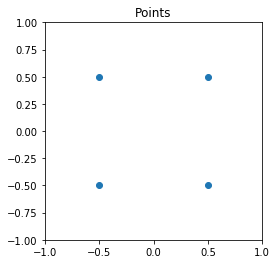

In [2]:
points = np.array([
    [-0.5, -0.5, 0],
    [0.5, -0.5, 0],
    [-0.5, 0.5, 0],
    [0.5, 0.5, 0]])
plt.scatter(points[:, 0], points[:, 1])
plt.title('Points')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.gca().set_aspect('equal')
plt.show()

Now we create a box and a `Voronoi` compute object.

In [3]:
L = 2
box = freud.box.Box.square(L)
voro = freud.locality.Voronoi()

Next, we use the `compute` method to determine the Voronoi polytopes (cells) and the `polytopes` property to return their coordinates. Note that we use `freud`'s *method chaining* here, where a compute method returns the compute object.

In [4]:
cells = voro.compute((box, points)).polytopes
print(cells)

[array([[-1., -1.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  0.],
       [-1.,  0.,  0.]]), array([[ 0., -1.,  0.],
       [ 1., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]]), array([[-1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  1.,  0.]]), array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [0., 1., 0.]])]


The `Voronoi` class has built-in plotting methods for 2D systems.

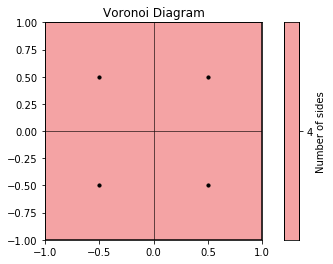

In [5]:
plt.figure()
ax = plt.gca()
voro.plot(ax=ax)
ax.scatter(points[:, 0], points[:, 1], s=10, c='k')
plt.show()

This also works for more complex cases, such as this hexagonal lattice.

In [6]:
def hexagonal_lattice(rows=3, cols=3, noise=0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Assemble a hexagonal lattice
    points = []
    for row in range(rows*2):
        for col in range(cols):
            x = (col + (0.5 * (row % 2)))*np.sqrt(3)
            y = row*0.5
            points.append((x, y, 0))
    points = np.asarray(points)
    points += np.random.multivariate_normal(mean=np.zeros(3), cov=np.eye(3)*noise, size=points.shape[0])
    # Set z=0 again for all points after adding Gaussian noise
    points[:, 2] = 0

    # Wrap the points into the box
    box = freud.box.Box(Lx=cols*np.sqrt(3), Ly=rows, is2D=True)
    points = box.wrap(points)
    return box, points

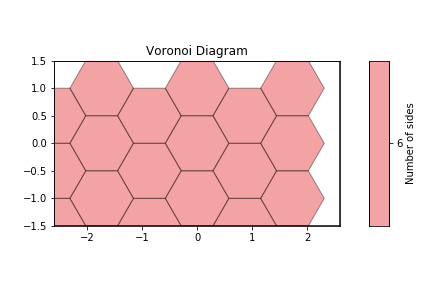

In [7]:
# Compute the Voronoi diagram and plot
box, points = hexagonal_lattice()
voro = freud.locality.Voronoi()
voro.compute((box, points))
voro

For noisy data, we see that the Voronoi diagram can change substantially. We perturb the positions with 2D Gaussian noise. Coloring by the number of sides of each Voronoi cell, we can see patterns in the defects: 5-gons and 7-gons tend to pair up.

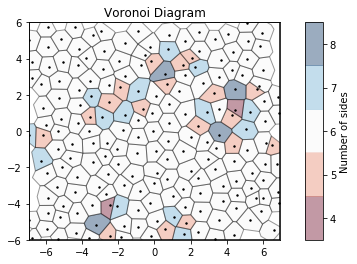

In [8]:
# Compute the Voronoi diagram
box, points = hexagonal_lattice(rows=12, cols=8, noise=0.03, seed=2)
voro = freud.locality.Voronoi()
voro.compute((box, points))

# Plot Voronoi with points and a custom cmap
plt.figure()
ax = plt.gca()
voro.plot(ax=ax, cmap='RdBu')
ax.scatter(points[:, 0], points[:, 1], s=2, c='k')
plt.show()

We can also compute the volumes of the Voronoi cells. Here, we plot them as a histogram:

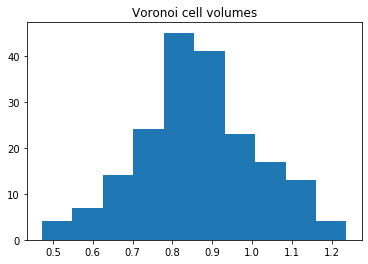

In [9]:
plt.hist(voro.volumes)
plt.title('Voronoi cell volumes')
plt.show()

The `Voronoi` class also computes a `freud.locality.NeighborList`, where particles are neighbors if they share an edge in the Voronoi diagram. The `NeighborList` effectively represents the bonds in the [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation). The neighbors are **weighted** by the length (in 2D) or area (in 3D) between them. The neighbor weights are stored in `voro.nlist.weights`.

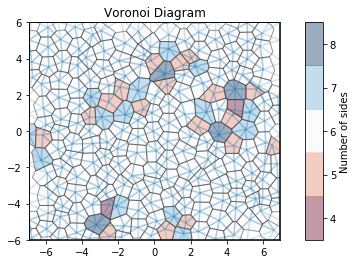

In [10]:
nlist = voro.nlist
line_data = np.asarray([[points[i],
                         points[i] + box.wrap(points[j] - points[i])]
                        for i, j in nlist])[:, :, :2]
line_collection = matplotlib.collections.LineCollection(line_data, alpha=0.2)
plt.figure()
ax = plt.gca()
voro.plot(ax=ax, cmap='RdBu')
ax.add_collection(line_collection)
plt.show()